# Fairness Analysis of Credit Risk Prediction

**Author**: Paul Belland

This notebook explores fairness metrics in machine learning classification using the German Credit dataset. The analysis includes:
- Exploratory data analysis of sensitive features
- Logistic regression model development
- Comprehensive fairness metrics evaluation
- Analysis of algorithmic bias across different demographic groups

In [9]:
# Import necessary libraries
import numpy as np
from numpy.random import default_rng
import pandas as pd
from scipy.optimize import minimize
import statsmodels.api as sm
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Set random seed for reproducibility
rng_seed = 42
rng = default_rng(rng_seed)
rngstate = np.random.RandomState(rng_seed)

## Data Loading and Initial Exploration

In [10]:
# Load the German Credit dataset
df_init = pd.read_csv('german_credit.csv')

print("Shape: ", df_init.shape)
df_init.head(5)

Shape:  (1000, 21)


,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2


## Dataset Overview

Our data relates to German creditors and contains features that determine their creditability. Key aspects include:

- **Sensitive variables**: Sex & Marital Status, Age (years), and Foreign Worker status
- **Target variable**: Creditability (binary: 1 for good credit, 0 for bad credit)
- **Features**: Account Balance, Credit Amount, Payment Status, Purpose, Savings/Stocks, Employment, etc.

The dataset is a stratified sample of 1000 credits from 1973-1975, with 700 good credits and an oversample of 300 bad credits to ensure proper analysis capabilities.

## Data Preprocessing

In [11]:
# Select relevant features and clean data
cols_retain = ['Creditability','Account Balance','Duration of Credit (month)',
               'Payment Status of Previous Credit','Purpose','Credit Amount',
               'Value Savings/Stocks', 'Length of current employment','Age (years)',
               'No of Credits at this Bank','Occupation','Duration in Current address',
               'Sex & Marital Status','Foreign Worker','Concurrent Credits']

df_processed = df_init[cols_retain]
df_processed = df_processed.dropna()
df_processed['Creditability'] = pd.to_numeric(df_processed['Creditability'])

## Exploratory Analysis of Sensitive Features

### Analysis 1: Creditability by Marital Status (Male)

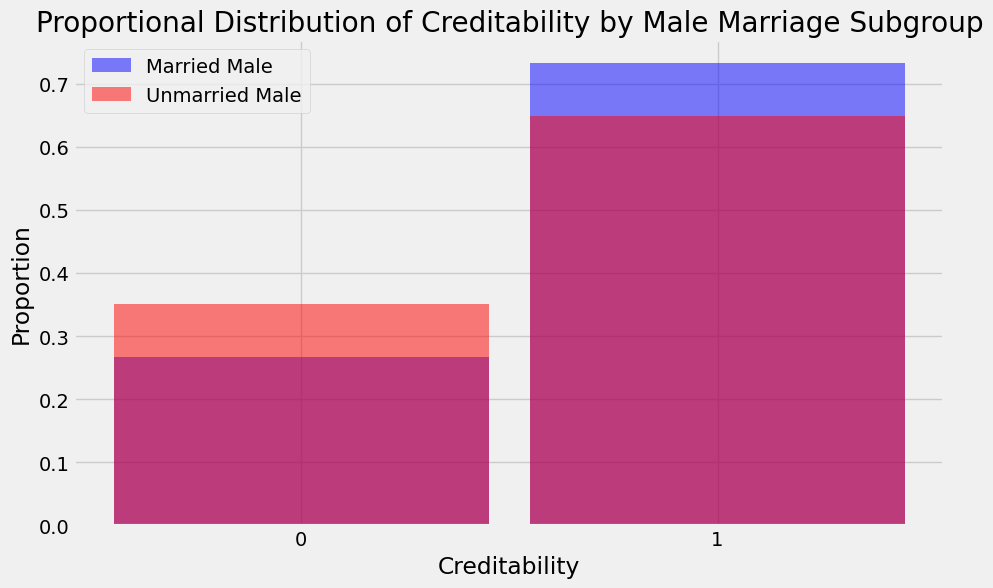

In [12]:
# Create subgroups for married vs unmarried males
df_1 = df_processed[df_processed['Sex & Marital Status'].isin([3])]  # married male
df_2 = df_processed[df_processed['Sex & Marital Status'].isin([2])]  # unmarried male

# Prepare data for visualization
df_1_cred = df_1['Creditability']
df_2_cred = df_2['Creditability']
bins = np.array([-0.5, 0.5, 1.5])

# Create proportional histogram
plt.figure(figsize=(10, 6))
plt.hist(df_1_cred, bins=bins, density=True, alpha=0.5, color='blue', label='Married Male', rwidth=0.9)
plt.hist(df_2_cred, bins=bins, density=True, alpha=0.5, color='red', label='Unmarried Male', rwidth=0.9)

plt.xlabel('Creditability')
plt.ylabel('Proportion')
plt.title('Proportional Distribution of Creditability by Male Marriage Subgroup')
plt.xticks([0, 1])
plt.legend()
plt.show()

The histogram shows that married men have approximately 72% creditability rate compared to 64% for unmarried men, suggesting marital status may influence credit approval likelihood.

### Analysis 2: Creditability by Age Group

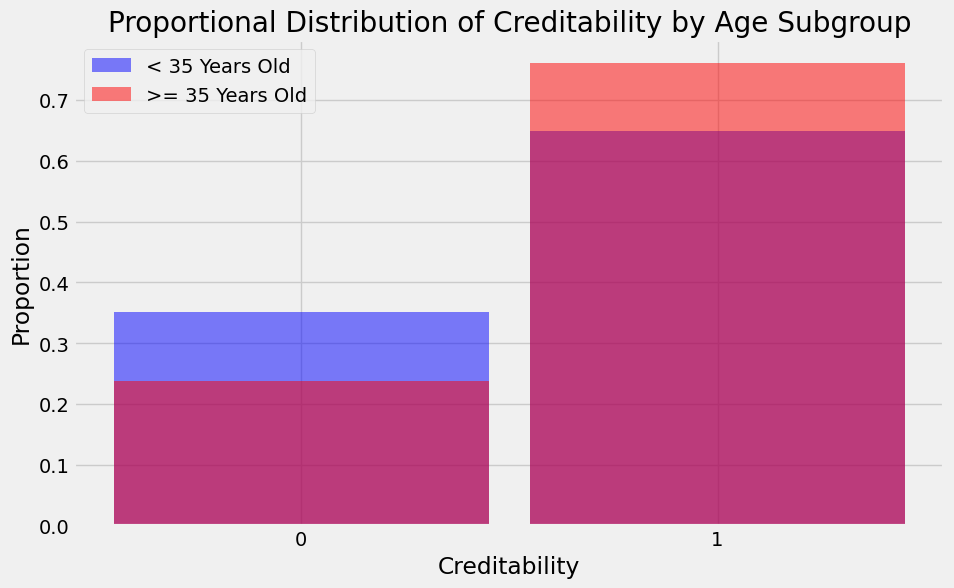

In [13]:
# Create age-based subgroups
df_a = df_processed[df_processed['Age (years)'] < 35]
df_b = df_processed[df_processed['Age (years)'] >= 35]

# Prepare data for visualization
df_a_cred = df_a['Creditability']
df_b_cred = df_b['Creditability']

# Create proportional histogram
plt.figure(figsize=(10, 6))
plt.hist(df_a_cred, bins=bins, density=True, alpha=0.5, color='blue', label='< 35 Years Old', rwidth=0.9)
plt.hist(df_b_cred, bins=bins, density=True, alpha=0.5, color='red', label='>= 35 Years Old', rwidth=0.9)

plt.xlabel('Creditability')
plt.ylabel('Proportion')
plt.title('Proportional Distribution of Creditability by Age Subgroup')
plt.xticks([0, 1])
plt.legend()
plt.show()

The age analysis reveals that individuals 35 or older have a 77% creditability rate compared to 65% for younger individuals, indicating age-based disparities in credit assessment.

## Logistic Regression Model Development

In [14]:
# Prepare data for modeling
Y = df_processed[['Creditability']]
X = df_processed.drop(columns=['Creditability'])

# Select features for the model
cols_retain = ['Account Balance','Credit Amount','Payment Status of Previous Credit',
               'Value Savings/Stocks','Length of current employment', 'Sex & Marital Status',
               'No of Credits at this Bank','Age (years)','Occupation']
X = X[cols_retain]

In [15]:
# Set up preprocessing pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Define categorical and numerical features
categorical_features = ['Account Balance', 'Sex & Marital Status', 
                       'Payment Status of Previous Credit', 'Value Savings/Stocks',
                       'Length of current employment', 'Occupation']
numerical_features = ['Credit Amount', 'No of Credits at this Bank','Age (years)']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Create model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=500))
])

In [16]:
# Split data and train model
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
model.fit(X_train, Y_train)

# Generate predictions
Y_pred = model.predict(X_test)

# Display classification report
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.60      0.40      0.48        75
           1       0.78      0.89      0.83       175

    accuracy                           0.74       250
   macro avg       0.69      0.64      0.65       250
weighted avg       0.72      0.74      0.72       250



/home/pbwz/repos/data-science/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Fairness Metrics Implementation

I'll implement functions to calculate key fairness metrics: True Positive Rate (TPR), False Positive Rate (FPR), and Positive Label Rate.

In [17]:
def tpr_metric(y_true, y_pred, x, s_feature, s_value):
    """Calculate True Positive Rate for a specific subgroup"""
    tp = 0
    ap = 0
    
    for i in range(len(x)):
        if x[s_feature].iloc[i] == s_value:
            if y_true.iloc[i] == 1:
                ap += 1
                if y_pred.iloc[i] == 1:
                    tp += 1
                    
    try:
        tpr = tp / ap
    except ZeroDivisionError:
        tpr = 0
        
    return tpr

def fpr_metric(y_true, y_pred, x, s_feature, s_value):
    """Calculate False Positive Rate for a specific subgroup"""
    fp = 0
    an = 0

    for i in range(len(x)):
        if x[s_feature].iloc[i] == s_value:
            if y_true.iloc[i] == 0:
                an += 1
                if y_pred.iloc[i] == 1:
                    fp += 1

    try:
        fpr = fp / an
    except ZeroDivisionError:
        fpr = 0

    return fpr

def poslabel_metric(y_pred, x, s_feature, s_value):
    """Calculate Positive Label Rate for a specific subgroup"""
    pl = 0
    tl = 0
    
    for i in range(len(x)):
        if x[s_feature].iloc[i] == s_value:
            tl += 1
            if y_pred.iloc[i] == 1:
                pl += 1
                
    try:
        poslabel = pl / tl
    except ZeroDivisionError:
        poslabel = 0
                
    return poslabel

## Fairness Analysis Results

### 1. Marital Status (Male) Analysis

In [18]:
# Prepare data for fairness analysis
Y_pred = pd.DataFrame(Y_pred, Y_test.index)
sensitive_features = ['Age (years)', 'Occupation', 'Sex & Marital Status']
A = X_test[sensitive_features]

# Create binary marital status feature
X_test["Married Men"] = np.where(X_test["Sex & Marital Status"] == 3, 1, 
                                 np.where(X_test["Sex & Marital Status"] == 2, 0, np.nan))
Y_test = Y_test.squeeze()
Y_pred = Y_pred.squeeze()

# Calculate fairness metrics
r_married = poslabel_metric(Y_pred, X_test, "Married Men", 1)
r_unmarried = poslabel_metric(Y_pred, X_test, "Married Men", 0)
demographic_parity = r_married - r_unmarried

tpr_married = tpr_metric(Y_test, Y_pred, X_test, "Married Men", 1)
tpr_unmarried = tpr_metric(Y_test, Y_pred, X_test, "Married Men", 0)
eq_opp_diff = tpr_married - tpr_unmarried

fpr_married = fpr_metric(Y_test, Y_pred, X_test, "Married Men", 1)
fpr_unmarried = fpr_metric(Y_test, Y_pred, X_test, "Married Men", 0)
fpr_diff = fpr_married - fpr_unmarried

print("Marital Status Fairness Metrics:")
print(f"Demographic Parity Difference: {demographic_parity:.3f}")
print(f"Equal Opportunity Difference: {eq_opp_diff:.3f}")
print(f"Equalized Odds (TPR, FPR): [{eq_opp_diff:.3f}, {fpr_diff:.3f}]")

Marital Status Fairness Metrics:
Demographic Parity Difference: 0.132
Equal Opportunity Difference: 0.114
Equalized Odds (TPR, FPR): [0.114, 0.140]


**Analysis**: The model shows bias favoring married males:
- 13% higher likelihood of positive predictions
- 11% higher true positive rate
- 14% higher false positive rate

This suggests the model may unfairly advantage married individuals in credit decisions.

### 2. Age Group Analysis (35+ vs <35)

In [19]:
# Create age binary feature
X_test['Age Over 35'] = np.where(X_test['Age (years)'] >= 35, 1, 0)

# Calculate fairness metrics
r_over35 = poslabel_metric(Y_pred, X_test, 'Age Over 35', 1)
r_under35 = poslabel_metric(Y_pred, X_test, 'Age Over 35', 0)
demographic_parity = r_over35 - r_under35

tpr_over35 = tpr_metric(Y_test, Y_pred, X_test, 'Age Over 35', 1)
tpr_under35 = tpr_metric(Y_test, Y_pred, X_test, 'Age Over 35', 0)
eq_opp_diff = tpr_over35 - tpr_under35

fpr_over35 = fpr_metric(Y_test, Y_pred, X_test, 'Age Over 35', 1)
fpr_under35 = fpr_metric(Y_test, Y_pred, X_test, 'Age Over 35', 0)
fpr_diff = fpr_over35 - fpr_under35

print("Age Group (35+) Fairness Metrics:")
print(f"Demographic Parity Difference: {demographic_parity:.3f}")
print(f"Equal Opportunity Difference: {eq_opp_diff:.3f}")
print(f"Equalized Odds (TPR, FPR): [{eq_opp_diff:.3f}, {fpr_diff:.3f}]")

Age Group (35+) Fairness Metrics:
Demographic Parity Difference: 0.192
Equal Opportunity Difference: 0.121
Equalized Odds (TPR, FPR): [0.121, 0.278]


**Analysis**: Significant age-based disparities:
- 19% higher positive prediction rate for 35+ individuals
- 12% higher true positive rate
- 28% higher false positive rate

Younger individuals face systematic disadvantage in credit approval.

### 3. Senior Age Analysis (60+ vs <60)

In [20]:
# Create senior age binary feature
X_test['Age Over 60'] = np.where(X_test['Age (years)'] >= 60, 1, 0)

# Calculate fairness metrics
r_over60 = poslabel_metric(Y_pred, X_test, 'Age Over 60', 1)
r_under60 = poslabel_metric(Y_pred, X_test, 'Age Over 60', 0)
demographic_parity = r_over60 - r_under60

tpr_over60 = tpr_metric(Y_test, Y_pred, X_test, 'Age Over 60', 1)
tpr_under60 = tpr_metric(Y_test, Y_pred, X_test, 'Age Over 60', 0)
eq_opp_diff = tpr_over60 - tpr_under60

fpr_over60 = fpr_metric(Y_test, Y_pred, X_test, 'Age Over 60', 1)
fpr_under60 = fpr_metric(Y_test, Y_pred, X_test, 'Age Over 60', 0)
fpr_diff = fpr_over60 - fpr_under60

print("Senior Age (60+) Fairness Metrics:")
print(f"Demographic Parity Difference: {demographic_parity:.3f}")
print(f"Equal Opportunity Difference: {eq_opp_diff:.3f}")
print(f"Equalized Odds (TPR, FPR): [{eq_opp_diff:.3f}, {fpr_diff:.3f}]")

Senior Age (60+) Fairness Metrics:
Demographic Parity Difference: 0.147
Equal Opportunity Difference: 0.123
Equalized Odds (TPR, FPR): [0.123, 0.158]


**Analysis**: Even stronger bias for senior individuals:
- 14.6% higher positive prediction rate
- 12% higher true positive rate  
- 16% higher false positive rate

This indicates potential over-approval of older individuals who may not be creditworthy.

## Model Performance Evaluation

In [21]:
# Generate final classification report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.60      0.40      0.48        75
           1       0.78      0.89      0.83       175

    accuracy                           0.74       250
   macro avg       0.69      0.64      0.65       250
weighted avg       0.72      0.74      0.72       250



## Key Findings

### Performance Metrics:
- **Precision**: 78% for creditworthy vs 60% for non-creditworthy (18% gap)
- **Recall**: 89% for creditworthy vs 40% for non-creditworthy (massive 49% gap)
- **F1-Score**: Well-balanced for creditworthy (0.83) but poor for non-creditworthy (0.48)

### Fairness Concerns:
1. **Systematic bias** favoring married individuals and older demographics
2. **High false positive rates** for protected groups may lead to over-approval
3. **Imbalanced data** (700 good vs 300 bad credits) likely contributes to performance issues

### Recommendations:
- Implement fairness-aware machine learning techniques
- Consider rebalancing training data or using weighted loss functions
- Regular fairness audits across demographic groups
- Investigate feature importance to understand bias sources